<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/Sonia_LondonBikeSharing_probando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Los datos del conjunto de datos de ciclismo bicicletas se agrupan por "Hora de inicio", lo que representa el recuento de nuevas bicicletas compartidas agrupadas por hora. Las acciones de larga duración no se toman en cuenta.

El propósito es intentar predecir las futuras bicicletas compartidas.

Vemos que tenemos una cantidad bastante buena de muestras.

Las variables son:

"timestamp" - timestamp field for grouping the data

"cnt" - the count of a new bike shares

"t1" - real temperature in C

"t2" - temperature in C "feels like"

"hum" - humidity in percentage

"windspeed" - wind speed in km/h

"weathercode" - category of the weather

"isholiday" - boolean field - 1 holiday / 0 non holiday

"isweekend" - boolean field - 1 if the day is weekend

"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description: 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional

In [4]:
import seaborn as sns

In [11]:
data = pd.read_csv('/content/london_merged.csv')

In [6]:
data.head(10)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [7]:
data.shape

(17414, 10)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [12]:
target = 'cnt'
features = [i for i in data.columns if i not in [target]]

print("Target:", target)
print("Variables de contexto:", features)

Target: cnt
Variables de contexto: ['timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']


In [14]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')

In [15]:
'''
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")
'''
data['hour'] = data.index.hour #horas
data["day_of_week"] = data.index.weekday
data["day_of_month"] = data.index.day
data["month"] = data.index.month
data["year"] = data.index.year


#timestamp
target = data['cnt'].values
t1 = data['t1'].values
t2 = data['t2'].values
hum = data['hum'].values
viento = data['wind_speed'].values
tiempo = data['weather_code'].values
festivo = data['is_holiday'].values
#is_weekend
#season
#year
mes = data['month'].values
dia = data['day_of_week'].values
hora = data['hour'].values


In [16]:
estacion = data['season'].values
festivo = data['is_holiday'].values


In [17]:
data["year_month"] = data.index.strftime('%Y-%m')

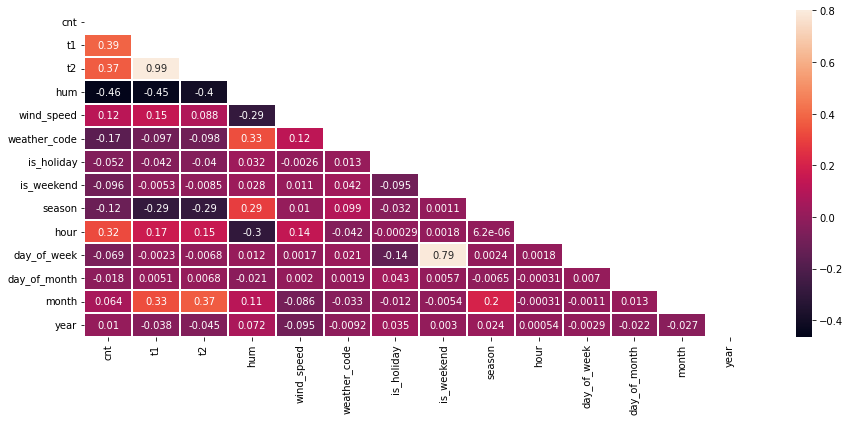

In [18]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1);

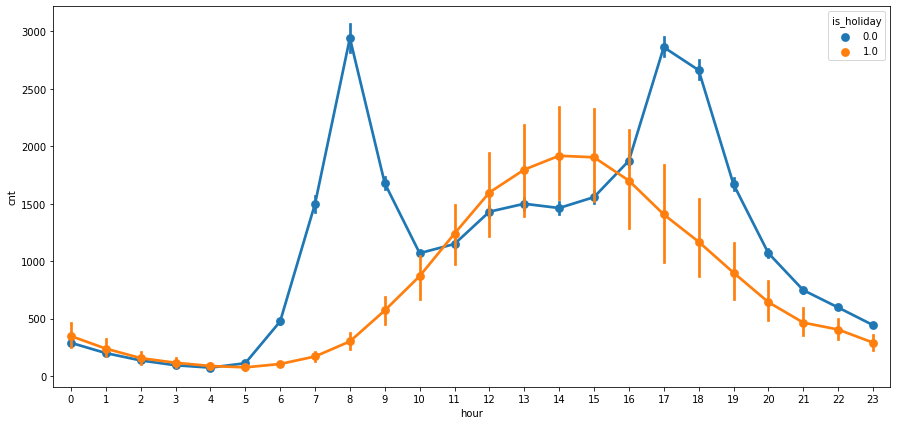

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.pointplot(x='hour', y='cnt', hue='is_holiday', data=data)

In [ ]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month,year,year_month
timestamp,,,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1,2015,2015-01
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1,2015,2015-01
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1,2015,2015-01
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1,2015,2015-01
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1,2015,2015-01


In [19]:
data_final = data[['t1',
 'hum',
 'wind_speed',
 'weather_code',
 'is_holiday',
 'is_weekend',
 'season',
 'hour',
 'month',
 'cnt'
 ]]

In [20]:
data_final.head()

,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
timestamp,,,,,,,,,,
2015-01-04 00:00:00,3.0,93.0,6.0,3.0,0.0,1.0,3.0,0,1,182
2015-01-04 01:00:00,3.0,93.0,5.0,1.0,0.0,1.0,3.0,1,1,138
2015-01-04 02:00:00,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,1,134
2015-01-04 03:00:00,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,1,72
2015-01-04 04:00:00,2.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,47


In [23]:
data_final = data_final.reset_index()

In [30]:
std_cnt = data.cnt.std()
std_cnt

1085.1080679362167

In [31]:
# Transformación de escala (ajustar el factor en función del problema)
def transform(x):
    return x/std_cnt
def inverse_transform(x_escalado):
    return x_escalado*std_cnt

In [25]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 'hum', 'wind_speed']

f_transformer = RobustScaler()

f_transformer = f_transformer.fit(data_final[f_columns].to_numpy())

data_final.loc[:, f_columns] = f_transformer.transform(
    data_final[f_columns].to_numpy()
)

In [32]:
data_final['cnt'] = transform(data_final['cnt'])

In [33]:
data_final.head()

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3.0,0.0,1.0,3.0,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1.0,0.0,1.0,3.0,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1.0,0.0,1.0,3.0,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1.0,0.0,1.0,3.0,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1.0,0.0,1.0,3.0,4,1,0.043314


In [48]:
data_final["season"] = data_final["season"].astype(int)
data_final["is_weekend"] = data_final["is_weekend"].astype(int)
data_final["is_holiday"] = data_final["is_holiday"].astype(int)
data_final["weather_code"] = data_final["weather_code"].astype(int)

In [50]:
data_final.head(5)

,timestamp,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,3,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,1,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,1,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,1,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,1,0,1,3,4,1,0.043314


In [54]:
data_final.drop(['weather_code'], axis = 'columns')

,timestamp,t1,hum,wind_speed,is_holiday,is_weekend,season,hour,month,cnt
0,2015-01-04 00:00:00,-1.1875,0.925,-0.857143,0,1,3,0,1,0.167725
1,2015-01-04 01:00:00,-1.1875,0.925,-0.952381,0,1,3,1,1,0.127176
2,2015-01-04 02:00:00,-1.2500,1.100,-1.428571,0,1,3,2,1,0.123490
3,2015-01-04 03:00:00,-1.3125,1.275,-1.428571,0,1,3,3,1,0.066353
4,2015-01-04 04:00:00,-1.3125,0.925,-0.809524,0,1,3,4,1,0.043314
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,-0.9375,0.325,0.380952,0,0,3,19,1,0.960273
17410,2017-01-03 20:00:00,-0.9375,0.325,0.571429,0,0,3,20,1,0.498568
17411,2017-01-03 21:00:00,-0.8750,0.200,0.857143,0,0,3,21,1,0.310568
17412,2017-01-03 22:00:00,-0.8750,0.075,0.761905,0,0,3,22,1,0.206431


In [57]:
t1 = data_final['t1'].values
hum = data_final['hum'].values
wind_speed = data_final['wind_speed'].values
is_weekend = data_final['is_weekend'].values


In [51]:
tiempo = data_final['weather_code'].values
festivo = data_final['is_holiday'].values
#is_weekend
#season
#year
estacion = data_final['season'].values
mes = data_final['month'].values
#dia = data_final['day_of_week'].values
hora = data_final['hour'].values

In [34]:
from my_utils_series_temporales import NAN, int2dummy, enventanar, info_enventanado

In [56]:
one_hot_mes = int2dummy(mes, 1, 12)
one_hot_hora = int2dummy(hora, 0, 23)
one_hot_estacion = int2dummy(estacion, 0, 3)

In [ ]:
timestamp	t1	hum	wind_speed	is_holiday	is_weekend	season	hour	month	cnt

In [59]:
target_transf = transform(target)

series = [target_transf, t1, hum, wind_speed, is_weekend, festivo]
se_saben_antes = [False, True, True, True, True, True]
nombres_series = ["target_transf", "t1", "hum", "wind_speed", "is_weekend", "festivo"]

# Variables calendario sobre las que hemos hecho one-hot encoding
for i in range(one_hot_mes.shape[1]):
    series.append(one_hot_mes[:,i])
    nombres_series.append("mes"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_hora.shape[1]):
    series.append(one_hot_hora[:,i])
    nombres_series.append("semana"+str(i+1))
    se_saben_antes.append(True)

for i in range(one_hot_estacion.shape[1]):
    series.append(one_hot_estacion[:,i])
    nombres_series.append("day"+str(i+1))
    se_saben_antes.append(True)

In [60]:
print(np.shape(series))
print(np.shape(se_saben_antes))

(46, 17414)
(46,)


In [61]:
lookback = 48 # lookback es otro sinónimo de W_in

# target=0 en siguiente línea quiere decir cuál es el índice del target en objeto "series":
X, y = enventanar(series, target=0, se_saben_antes=se_saben_antes,
                  W_in=lookback, W_out=24)

print(X.shape, np.shape(y))

(17414, 48, 46) (17414, 24)


In [62]:
print(X.shape)
print(np.shape(target))

(17414, 48, 46)
(17414,)


In [74]:
y.shape()

TypeError: ignored

In [81]:
print(y[-23:, :])#48 time steps y 8 features, var. contexto

[[0.04515679 0.03962739 0.00921567 0.02764702 0.07649008 0.39996016
  1.29664505 2.67623114 1.25056669 0.60915592 0.58611674 0.76029294
  0.809136   0.70499891 0.77872428 1.1068022  2.52693725 2.04587918
  0.96027302 0.49856785 0.31056815 0.20643105 0.12809784        nan]
 [0.03962739 0.00921567 0.02764702 0.07649008 0.39996016 1.29664505
  2.67623114 1.25056669 0.60915592 0.58611674 0.76029294 0.809136
  0.70499891 0.77872428 1.1068022  2.52693725 2.04587918 0.96027302
  0.49856785 0.31056815 0.20643105 0.12809784        nan        nan]
 [0.00921567 0.02764702 0.07649008 0.39996016 1.29664505 2.67623114
  1.25056669 0.60915592 0.58611674 0.76029294 0.809136   0.70499891
  0.77872428 1.1068022  2.52693725 2.04587918 0.96027302 0.49856785
  0.31056815 0.20643105 0.12809784        nan        nan        nan]
 [0.02764702 0.07649008 0.39996016 1.29664505 2.67623114 1.25056669
  0.60915592 0.58611674 0.76029294 0.809136   0.70499891 0.77872428
  1.1068022  2.52693725 2.04587918 0.96027302 0

In [83]:
x_ = X[:-23, :, :]
y_ = y[:-23, :]

In [85]:
print(x_.shape, np.shape(y_))

(17391, 48, 46) (17391, 24)


In [88]:
train_perc  = .8
punto_corte = int(len(X)*train_perc)

In [91]:
X_train      = x_[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
y_train      = y_[lookback:punto_corte]      # elimino los lookback primeros al tener NANs
target_train = target[lookback:punto_corte] # elimino los lookback primeros al tener NANs
#fechas_train = fechas[lookback:punto_corte] # elimino los lookback primeros al tener NANs

X_test       = x_[punto_corte:]
y_test       = y_[punto_corte:]
target_test  = target[punto_corte:]
#fechas_test  = fechas[punto_corte:]

print(np.shape(target_train))
print(np.shape(target_test))

(13883,)
(3483,)


In [92]:
print(X_train.shape, y_train.shape)

(13883, 48, 46) (13883, 24)


In [93]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [102]:
model_0 = Sequential()
model_0.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))  # input_shape=[time steps, features]
model_0.add(Dense(100, activation='relu'))
model_0.add(Dense(n_outputs))
model_0.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')

In [103]:
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               197600    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 24)                2424      
                                                                 
Total params: 220,124
Trainable params: 220,124
Non-trainable params: 0
_________________________________________________________________


In [97]:
history_model_0 = model_0.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

Epoch 1/100
391/391 [==============================] - 49s 115ms/step - loss: 0.6225 - val_loss: 0.4324
Epoch 2/100
391/391 [==============================] - 46s 117ms/step - loss: 0.2473 - val_loss: 0.2931
Epoch 3/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1790 - val_loss: 0.2521
Epoch 4/100
391/391 [==============================] - 45s 116ms/step - loss: 0.1498 - val_loss: 0.2490
Epoch 5/100
391/391 [==============================] - 45s 114ms/step - loss: 0.1275 - val_loss: 0.3230
Epoch 6/100
391/391 [==============================] - 45s 116ms/step - loss: 0.1142 - val_loss: 0.2825
Epoch 7/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1686 - val_loss: 0.2986
Epoch 8/100
391/391 [==============================] - 44s 113ms/step - loss: 0.1268 - val_loss: 0.2734
Epoch 9/100
391/391 [==============================] - 45s 115ms/step - loss: 0.1031 - val_loss: 0.2688
Epoch 10/100
391/391 [==============================] - 45s 116m

KeyboardInterrupt: ignored

In [104]:
plt.plot(history_model_0.history['loss'], label='Training loss')
plt.plot(history_model_0.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.legend();

NameError: ignored

In [99]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [105]:
epochs = 100
batch_size = 32
Nval = 200
control_sobreajuste_val = True

if not control_sobreajuste_val:
    history = model_0.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=32)

else:    
    acum_tr_mse = []
    acum_val_mse = []
    modelpath="model_current_best.h5"
    checkpoint = ModelCheckpoint(modelpath, monitor='val_mse', verbose=2, # val_mean_squared_error
                                 save_best_only=True,
                                 mode='min') # graba sólo los que mejoran en validación

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        #aux = aug.scaling(aug.jitter(X_train[:-Nval])) # data augmentation con jitter
        aux = X_train[:-Nval]
        history = model_0.fit(aux, y_train[:-Nval],
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(X_train[-Nval:], y_train[-Nval:]))
        
        acum_tr_mse  += history.history['mse'] # mean_squared_error
        acum_val_mse += history.history['val_mse'] # val_mean_squared_error
        
        if (e+1)%50 == 0:
            grafica_entrenamiento(acum_tr_mse, acum_val_mse)


Epoch 1: val_mse improved from inf to 0.60246, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.60246 to 0.33128, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.33128 to 0.24894, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.24894

Epoch 1: val_mse improved from 0.24894 to 0.23830, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.23830 to 0.19653, saving model to model_current_best.h5

Epoch 1: val_mse improved from 0.19653 to 0.17405, saving model to model_current_best.h5

Epoch 1: val_mse did not improve from 0.17405


KeyboardInterrupt: ignored

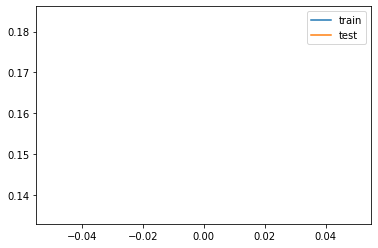

In [107]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();